In [3]:
import numpy as np
import pandas as pd
import os
import gc
import csv
import re
%config InlineBackend.figure_format ='retina' #double the resolution for retina displays
import seaborn as sns
import matplotlib.pyplot as plt

#Jupyter setup to expand cell display to 100% width on your screen (optional)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.despine()

def get_def(x):
    return(dfss.loc[dfss['Column_name'] == '%s'%x].values[0][3])

<Figure size 432x288 with 0 Axes>

# Pre-process Data (UKBB+ HMTL side file)

In [22]:
dfss=pd.read_csv("summary.csv")
df=pd.read_hdf("toy_ex.h5")

,Column_name,Type_variable,Number_values,Kind_measurement,Coding_used,Cardinality
0,eid,Sequence,502543,Encoded anonymised participant ID,0,0
1,31-0.0,Categorical (single),502543,Sex,9,2
2,34-0.0,Integer,502543,Year of birth,0,0
3,52-0.0,Categorical (single),502543,Month of birth,8,12
4,53-0.0,Date,502543,Date of attending assessment centre,0,0
5,54-0.0,Categorical (single),502543,UK Biobank assessment centre,10,26
6,55-0.0,Categorical (single),502543,Month of attending assessment centre,8,12
7,21003-0.0,Integer,502543,Age when attended assessment centre,0,0
8,21022-0.0,Integer,502543,Age at recruitment,0,0
9,21721-0.0,Categorical (single),502543,Consent authorisation,123,1056


## Handling poor encoding

-  Drop columns with too large cardinality (> 4 answers)

In [26]:
L_drop=[]
for item in df.columns:
    if (int(dfss.loc[dfss['Column_name'] == '%s'%item].values[0][5])>4):
        L_drop.append('%s'%item) 
df=df.drop(L_drop, axis=1)
gc.collect() # empty RAM

In [8]:
len(L_drop)

75

## Handling outliers

- Remove columns with low variance ( <0.2 )

In [11]:
df=df.loc[:, df.std()>0.2]

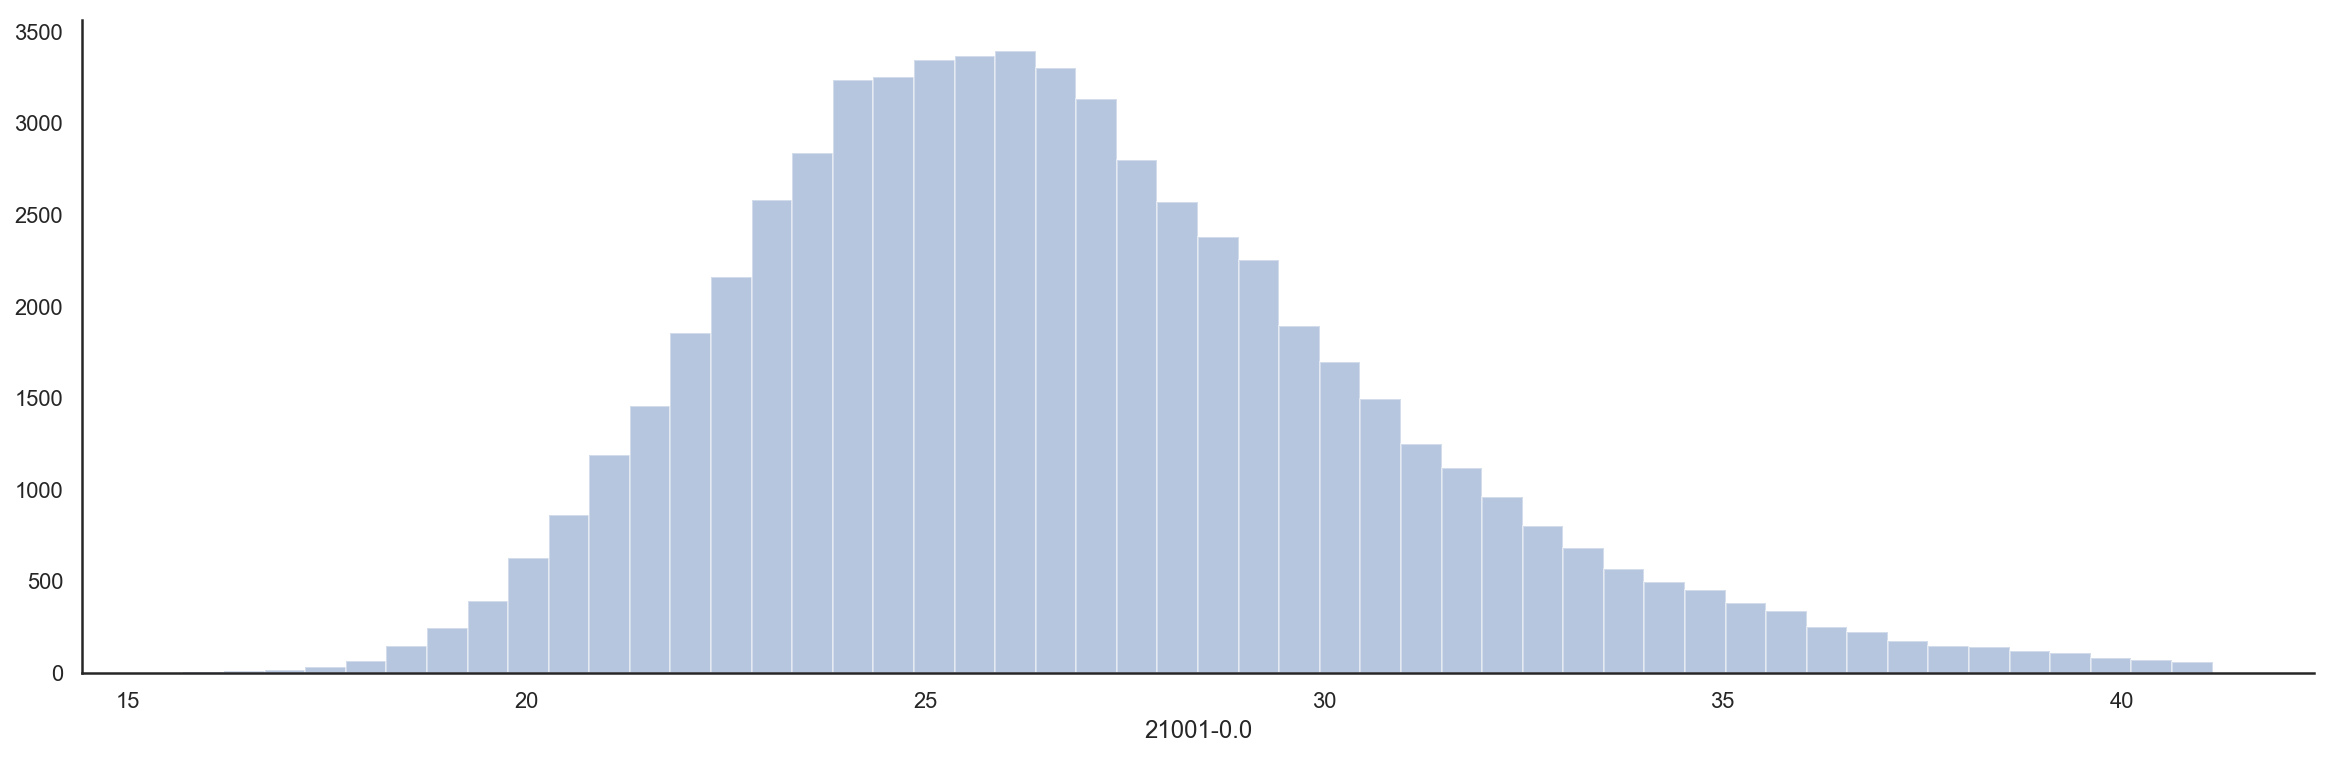

In [43]:
# The case for BMI (#21001-0.0)
fig1,ax1=plt.subplots(figsize=(20, 6))
sns.distplot(df["21001-0.0"], kde=False, rug=False);
sns.despine()

The large spread of BMI makes the predicting task more hazardous. Linear assumptions might be particulary wrong.

In [40]:
df[df["21001-0.0"] > np.percentile(df["21001-0.0"],1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356280 entries, 0 to 502542
Columns: 236 entries, 3-0.0 to 30530-0.0
dtypes: float64(236)
memory usage: 644.2 MB


- Remove every outliers in every other columns (keep only values rows within 3 sd)

In [12]:
df=df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

## Split data into model selection and statistical inference

- Split 70/30 %

In [15]:
model_selection_dataset = df.sample(frac=0.7,random_state=0)
inference_dataset = df.drop(model_selection_dataset.index)

In [95]:
any(np.isinf(model_selection_dataset ))
#a_infs = np.where(np.isinf(model_selection_dataset))
#print(a_infs)

True

- Split model selection into training and validation set (Here named _test set_)

In [16]:
train_dataset = model_selection_dataset.sample(frac=0.7,random_state=0)
test_dataset = model_selection_dataset.drop(train_dataset.index)

- Inspect the <b> <span style="color:#F1C40F">TRAINING  </span> </b> data

In [17]:
train_stats = train_dataset.describe()
train_stats.pop("21001-0.0")  #BMI
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
3-0.0,29879.0,421.305967,149.264447,124.000000,315.000000,389.000000,493.000000,1092.000000
4-0.0,29879.0,535.067907,142.631958,217.000000,431.000000,508.000000,613.000000,1084.000000
5-0.0,29879.0,249.406807,95.367511,19.000000,189.000000,233.000000,291.000000,667.000000
6-0.0,29879.0,39.215235,47.429520,3.000000,11.000000,21.000000,52.000000,720.000000
31-0.0,29879.0,0.452324,0.497730,0.000000,0.000000,0.000000,1.000000,1.000000
34-0.0,29879.0,1952.344054,7.967345,1936.000000,1946.000000,1951.000000,1959.000000,1970.000000
46-0.0,29879.0,30.582115,10.942685,0.000000,22.000000,29.000000,38.000000,63.000000
47-0.0,29879.0,32.793601,10.934577,0.000000,24.000000,31.000000,40.000000,65.000000
68-0.0,29879.0,6.220389,0.414516,6.000000,6.000000,6.000000,6.000000,7.000000
74-0.0,29879.0,3.336457,1.347319,0.000000,2.000000,3.000000,4.000000,10.000000


- Split features from label

In [18]:
train_labels = train_dataset.pop('21001-0.0')
test_labels = test_dataset.pop('21001-0.0')
inference_labels=inference_dataset.pop('21001-0.0')

- Normalize the data, <b> <span style="color:#F1C40F">NOT THE OUTPUT/LABEL  </span> </b>

In [19]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [51]:
normed_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29879 entries, 77359 to 224564
Columns: 216 entries, 3-0.0 to 30530-0.0
dtypes: float64(216)
memory usage: 49.5 MB


- Store index for replicability (bootstrap for sensitivity analysis,... )

In [39]:
List_index_random_split=normed_train_data.index.values
List_index_random_split

array([330157, 455362, 140010, ..., 418044, 230839, 376125])

In [40]:
np.savetxt("List_index_random_split_00.csv",List_index_random_split, fmt="%d",delimiter=",") #https://stackoverflow.com/questions/6081008/dump-a-numpy-array-into-a-csv-file, to encode as int (float if not)

- Replace non-sense headers (ATTENTION, HEADERS ARE NOT UNIQUE, (WHEN YOU DROP COLUMNS...)

In [23]:
New_Headers=[get_def(x) for x in normed_train_data.columns.values]

In [24]:
get_def('3-0.0')
normed_train_data.columns=New_Headers
normed_test_data.columns=New_Headers

# Understanding the correlation in the dataset

## Building up intuition by visually inspecting the correlations

- Computing the correlation matrix

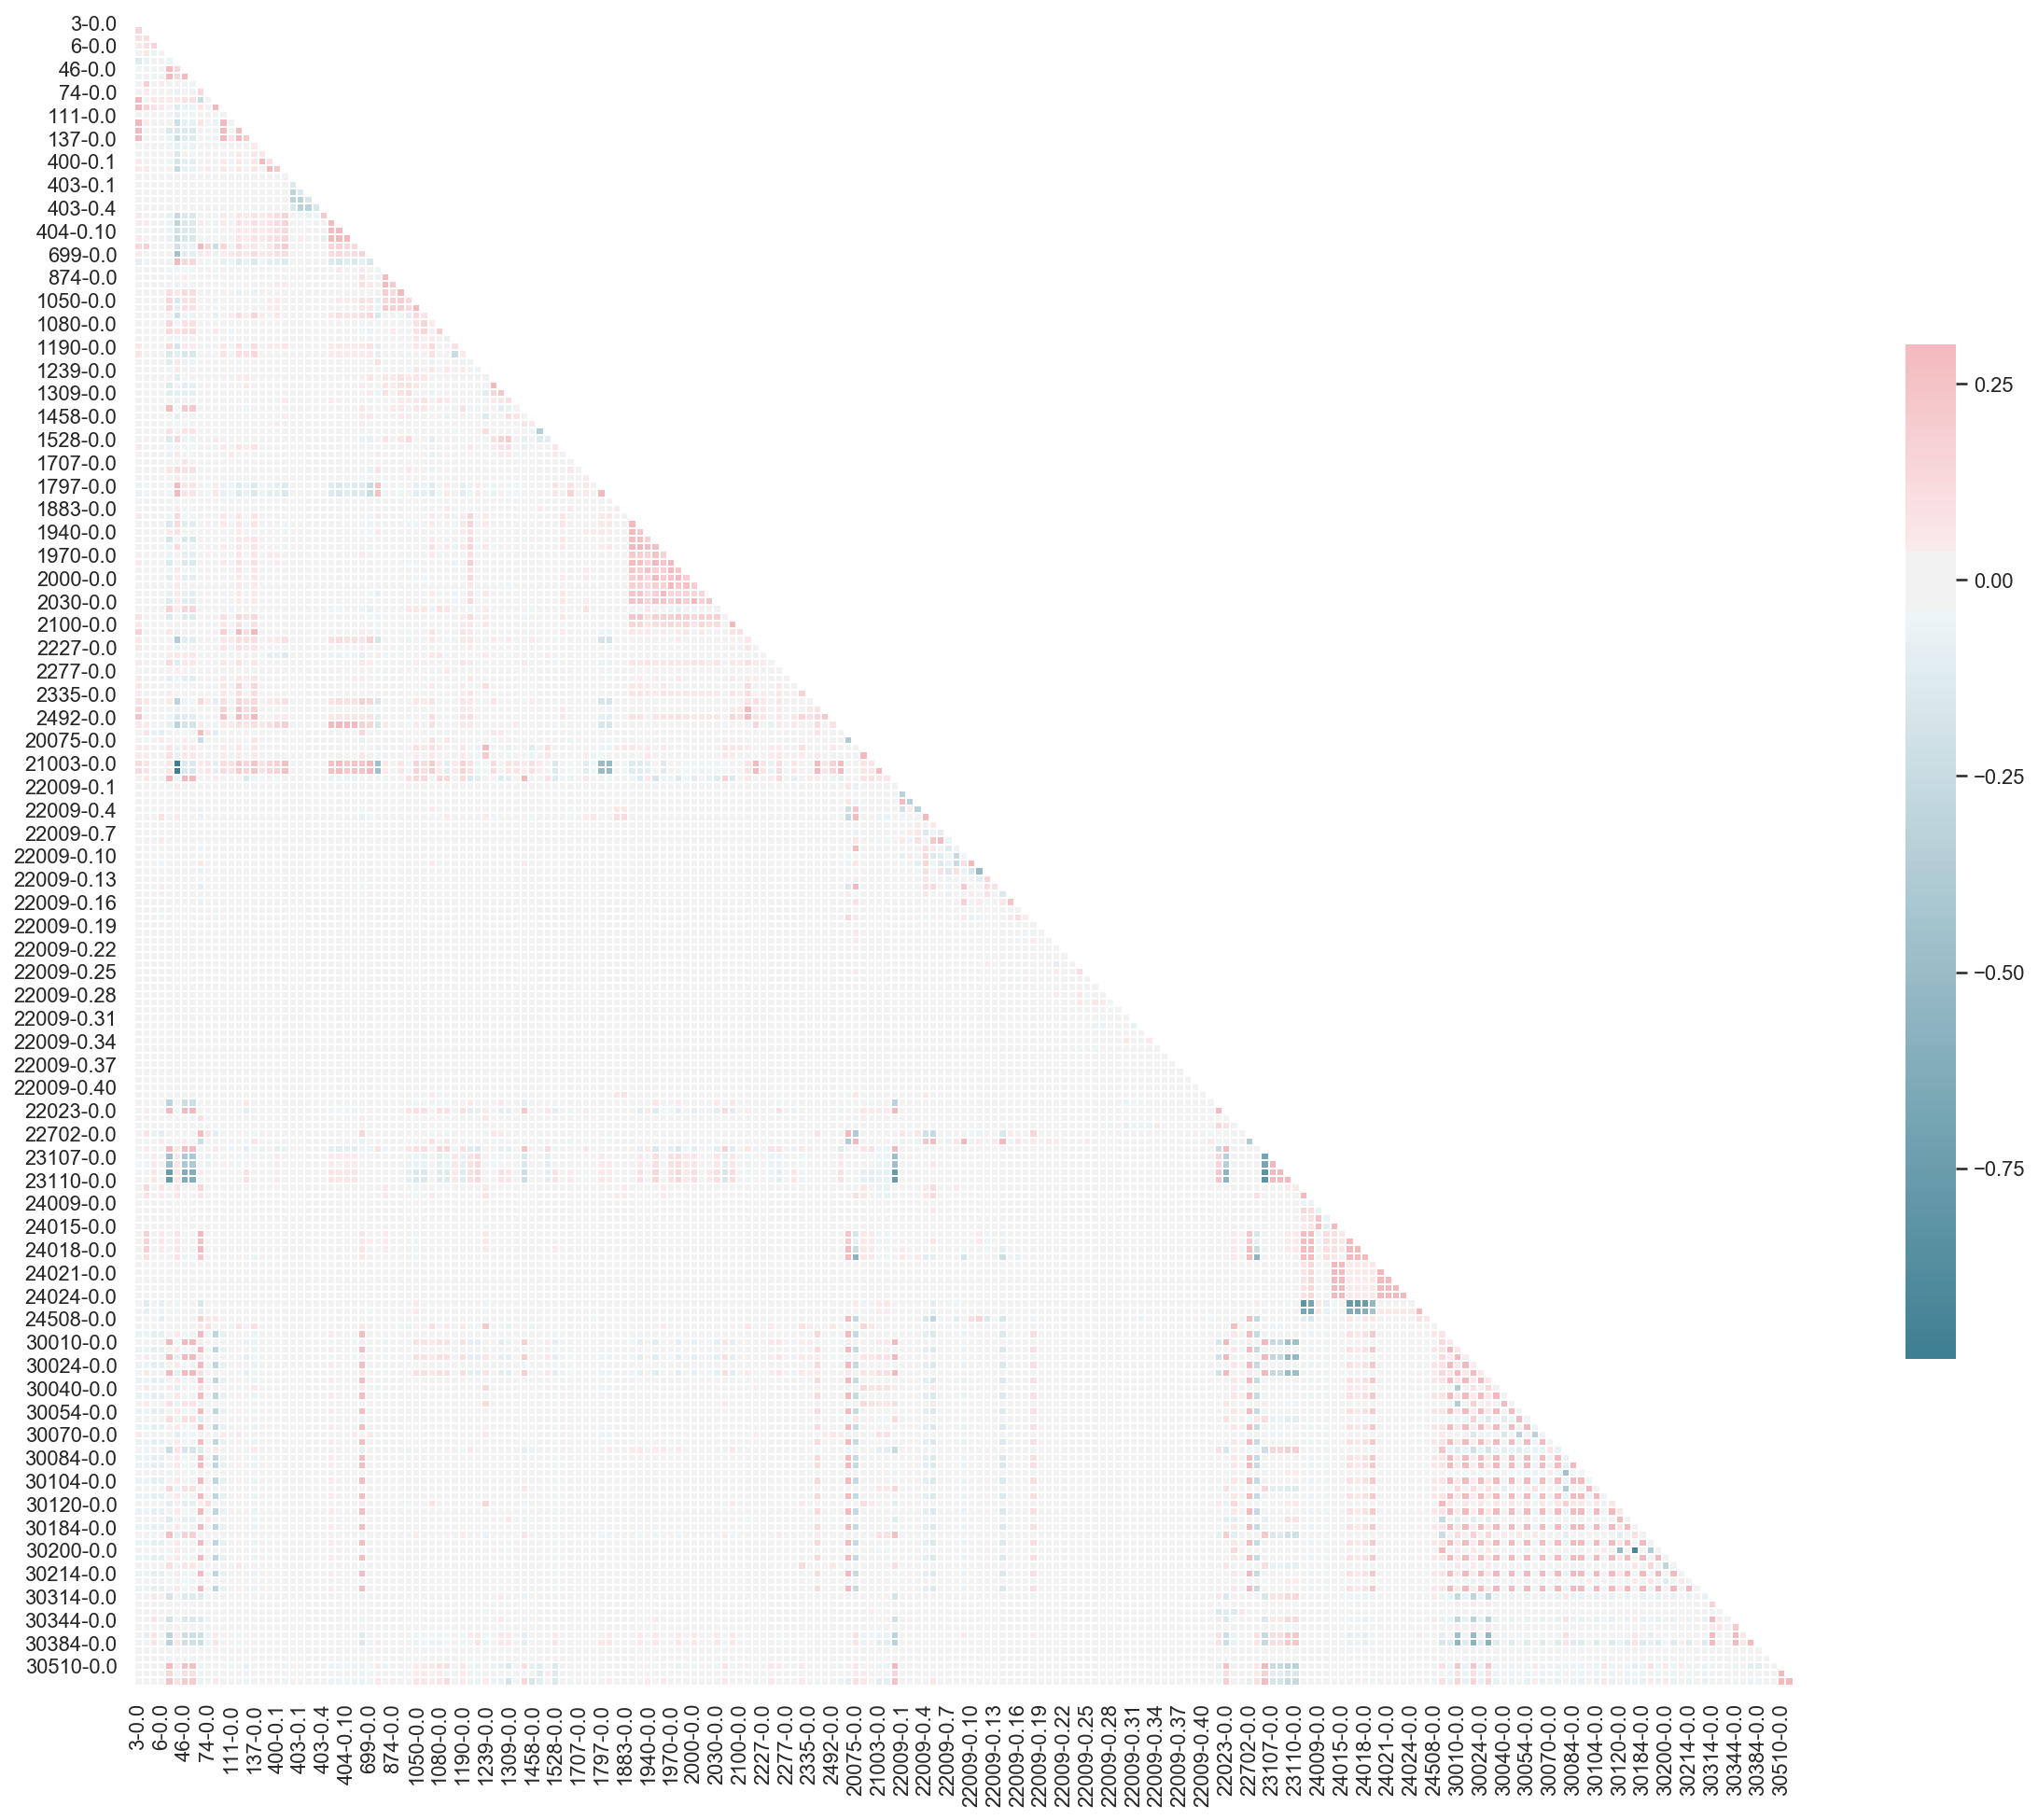

In [20]:
# Compute the correlation matrix
corr = normed_train_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#plt.savefig("heatmap.pdf", dpi=800,bbox_inches='tight')

- List of highly correlated features

In [52]:
Matrix_correlation_indices=np.where(np.abs(corr)>0.81)
Matrix_correlation_indices

(array([  0,   1,   2,   3,   4,   5,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         88,  89,  90,  91,  92,  93,  94,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 107, 108, 109, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123]),
 array([  0,   1,   2,   3,   4,   5,  80,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  

- List of  correlated features with BMI

In [ ]:
# Compute correlation between BMI and all features
Correlation_with_BMI=np.corrcoef(normed_train_data,train_labels,rowvar=False)

In [21]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(np.abs(upper[column])> 0.8)]
upper
#to_drop
normed_train_data=normed_train_data.drop(to_drop, axis=1)
normed_test_data=normed_test_data.drop(to_drop, axis=1)

## Dimensionality reduction with PCA

- Computing PCA

In [52]:
normed_train_data = normed_train_data.reset_index()
normed_train_data.pop('index')
#normed_train_data.pop('level_0')
from sklearn.decomposition import PCA
pca = PCA(2)  # project from 248 to 2 dimensions
projected_normed_train_data = pca.fit_transform(normed_train_data)
print(normed_train_data.shape)
print(projected_normed_train_data.shape)

(29879, 174)
(29879, 2)


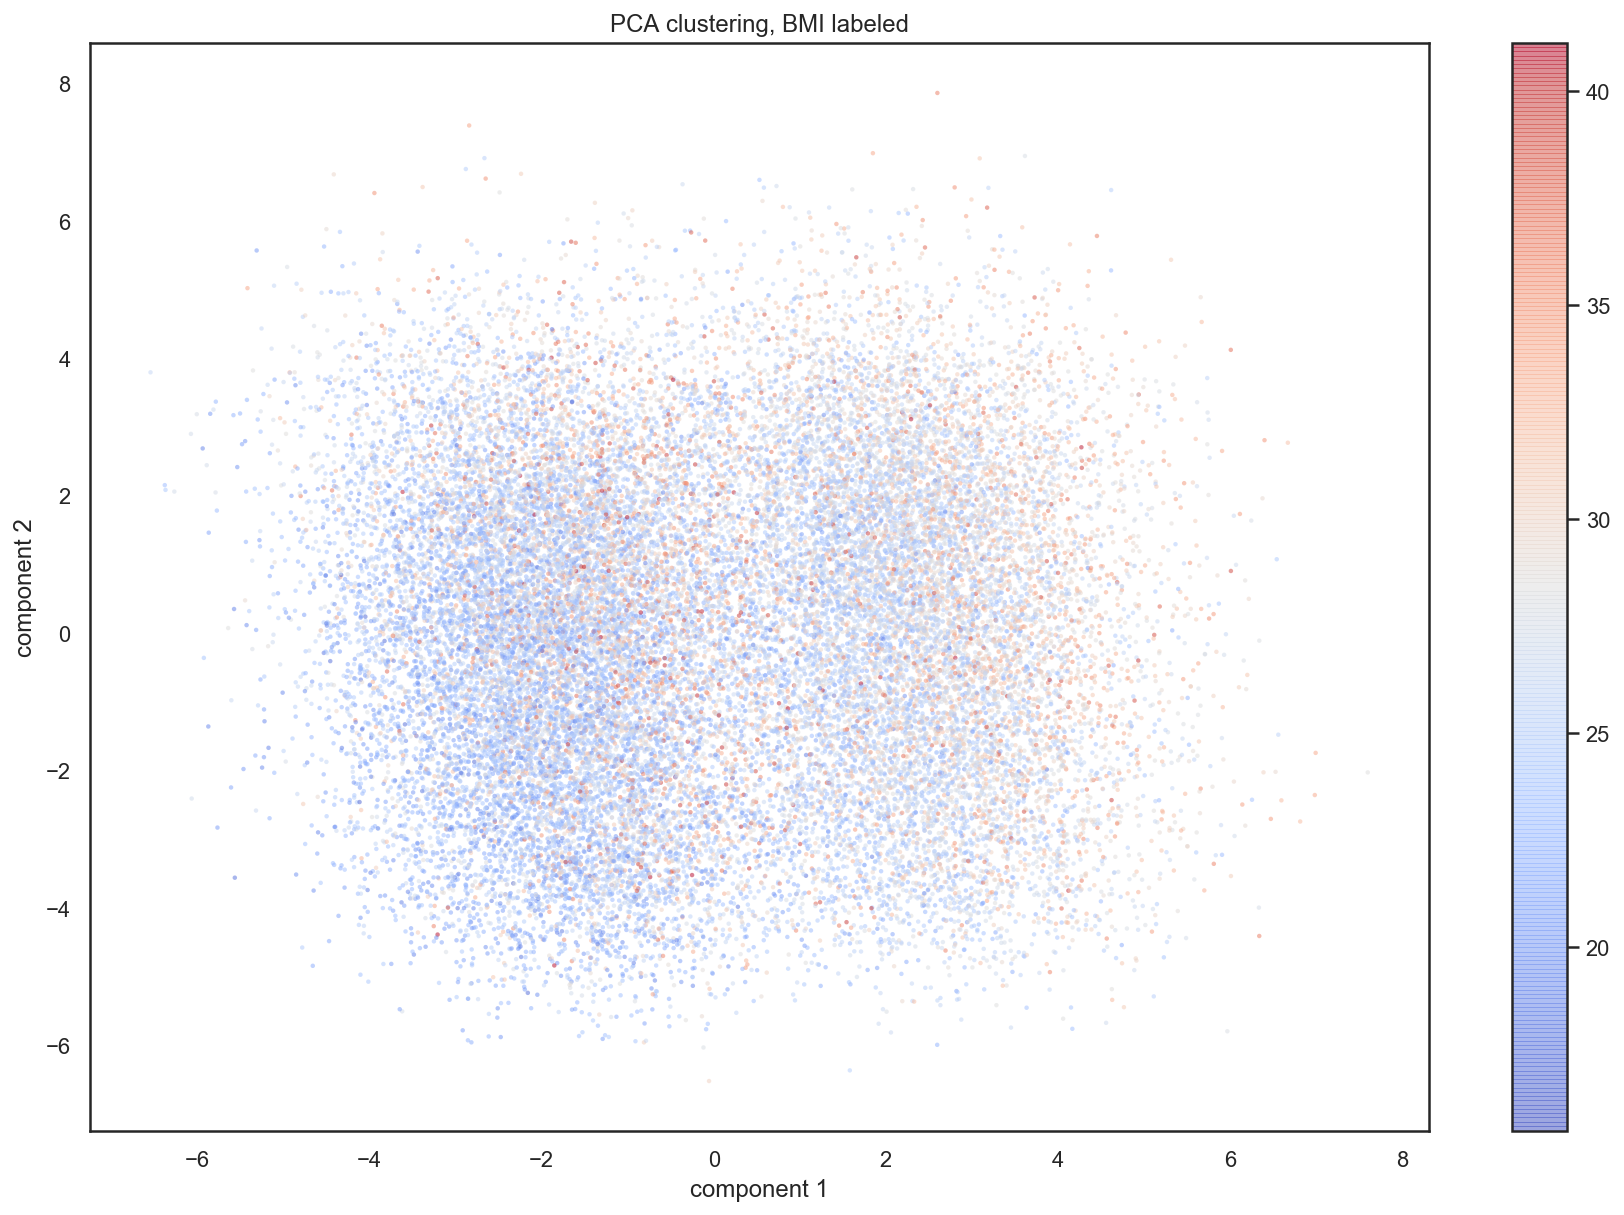

In [53]:
fig1,ax1=plt.subplots(figsize=(15, 10))
plt.scatter(projected_normed_train_data[:, 0], projected_normed_train_data[:, 1],s=[5]*159138,
            c=train_labels, cmap='coolwarm',edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA clustering, BMI labeled')
plt.colorbar();
plt.savefig("pca_with_uncorrelated_29879_216-to-174_features_without_outliers.pdf", dpi=600,bbox_inches='tight')

- How many components should we be using?

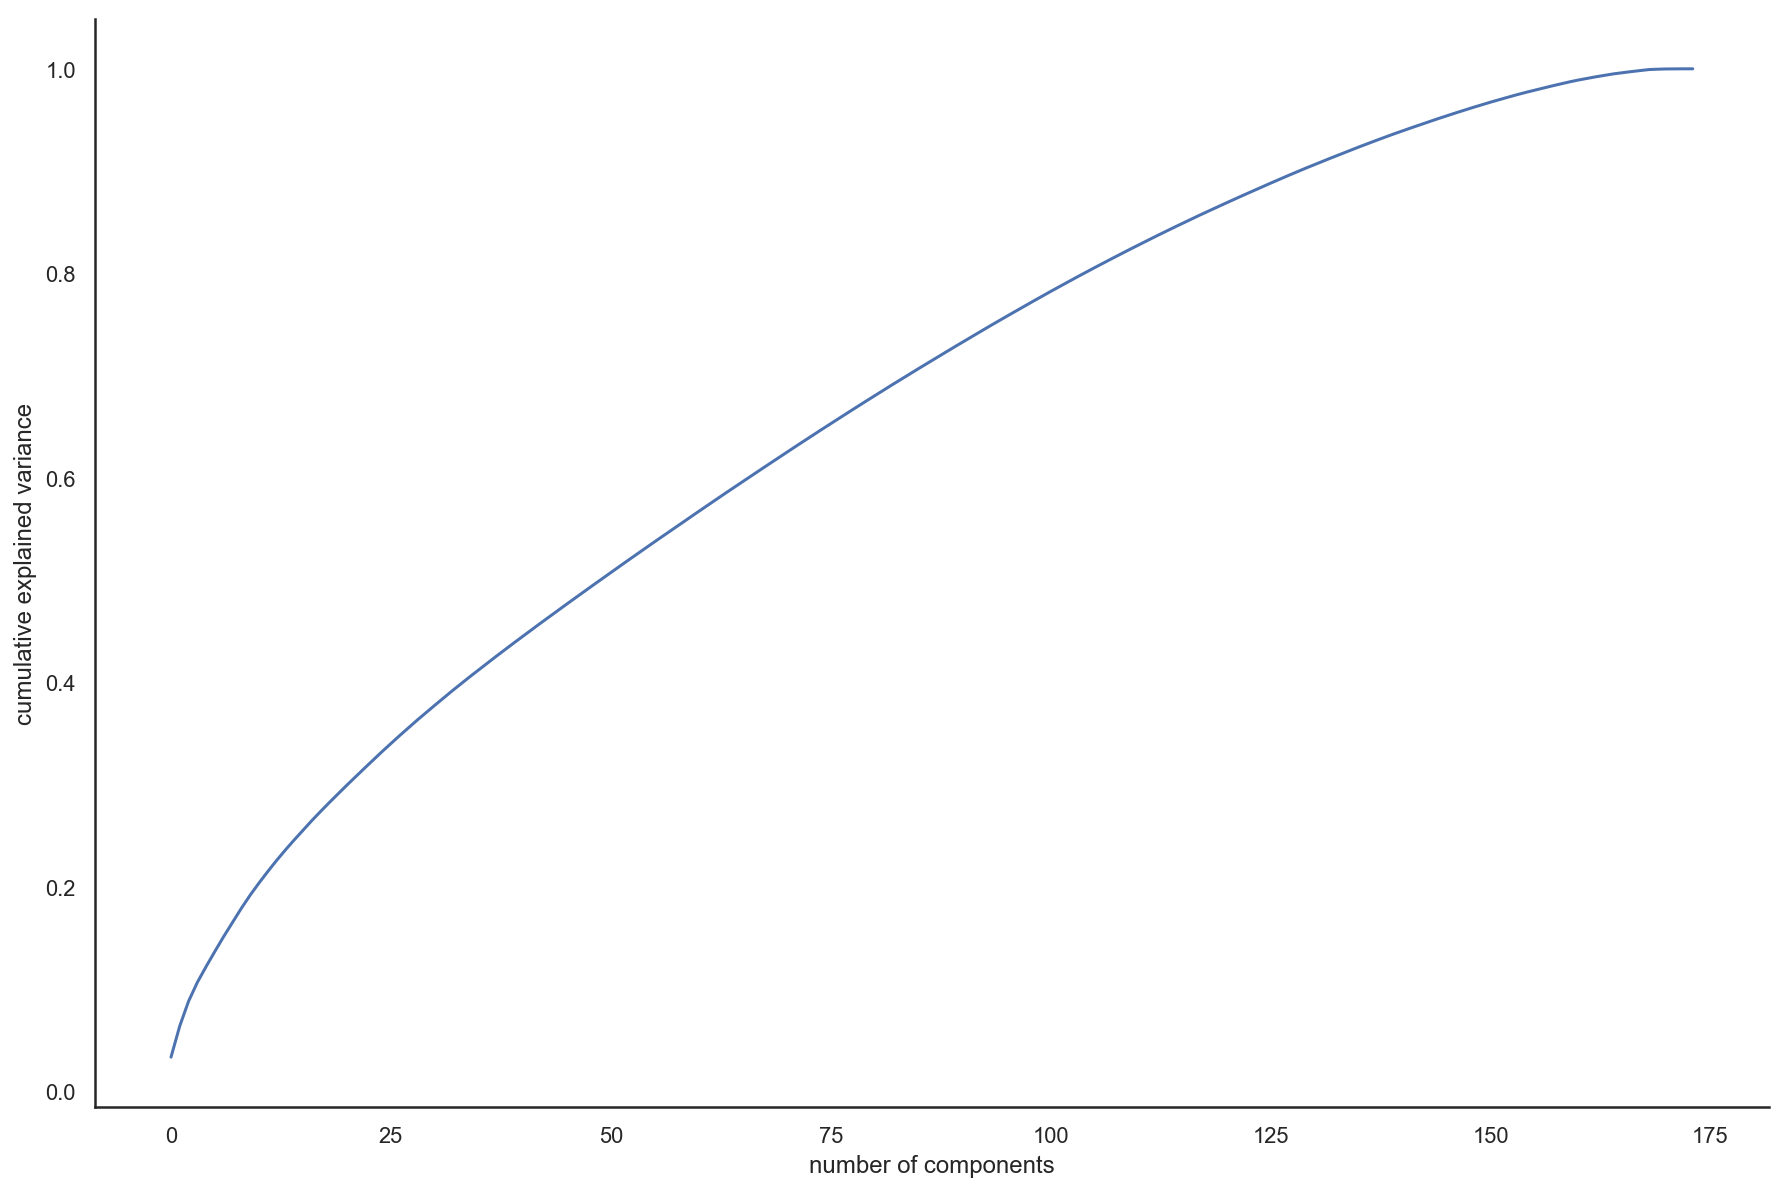

In [54]:
fig1,ax1=plt.subplots(figsize=(15, 10))
pca = PCA().fit(normed_train_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
sns.despine()
plt.savefig("Cumulative variance_uncorrelated_29879_216-to-174_features_without_outliers.pdf", dpi=800,bbox_inches='tight')

We see that for this data, nearly 150 components are required to preserve 90% of the variance: this tells us that the data is intrinsically **very high dimensional**—it can't be described linearly with just a few components.

# Regularisation Techniques

## L1/L2 regularisation

- Visuals

Computing regularization path using the lasso...
Computing regularization path using the elastic net...


(-0.6007019401933955,
 3.1370320693458456,
 -1.8504647169233308,
 0.7948478976312086)

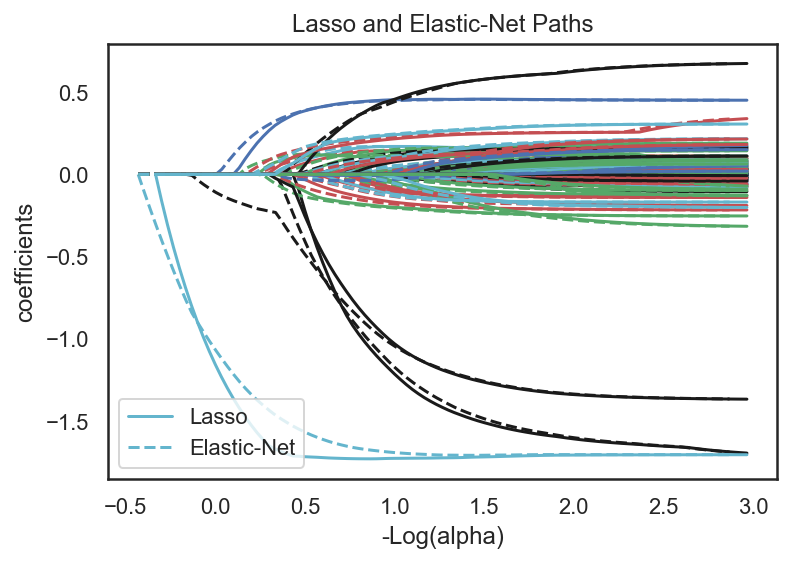

In [56]:
from itertools import cycle
from sklearn.linear_model import lasso_path, enet_path
X = normed_train_data
y = train_labels

# Compute paths

eps = 5e-4  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path( X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

# Display results

plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)

for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')

We see that the elastic net is *pushed towards* a regular LASSO (L1 ratio=1)

- Individual paths for Lasso and Elastic Net

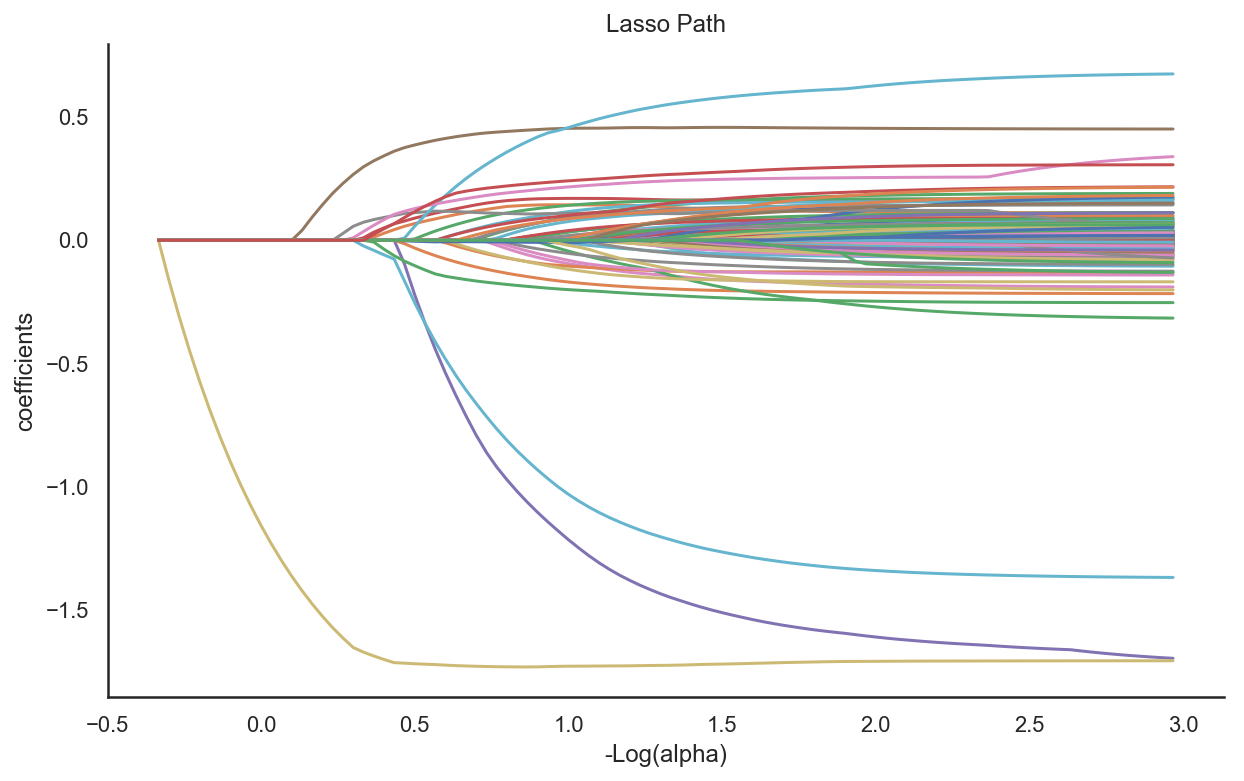

In [57]:
fig, ax = plt.subplots(figsize=(10, 6)) #create
for coef_l in zip(coefs_lasso):
    l1 = ax.plot(neg_log_alphas_lasso, coef_l[0])


#ax.plot(neg_log_alphas_lasso, coef_l)
ax.set(xlabel='ICD code', ylabel='occurence',
       title='Distribution of ICD codes')
sns.despine()
#ax.xaxis.set_major_locator(plt.MaxNLocator(12))
#plt.axhline(y=300, color='goldenrod',linewidth=2,linestyle='--')
#plt.text('D166', 1500, 'threshold: <300', {'color': 'goldenrod', 'fontsize': 15})
#plt.savefig("test_ICD.pdf", dpi=150)
#plt.savefig("test_ICD_1.pdf", dpi=600)
plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')
plt.savefig("lasso_path_more_variables.pdf", dpi=1000)

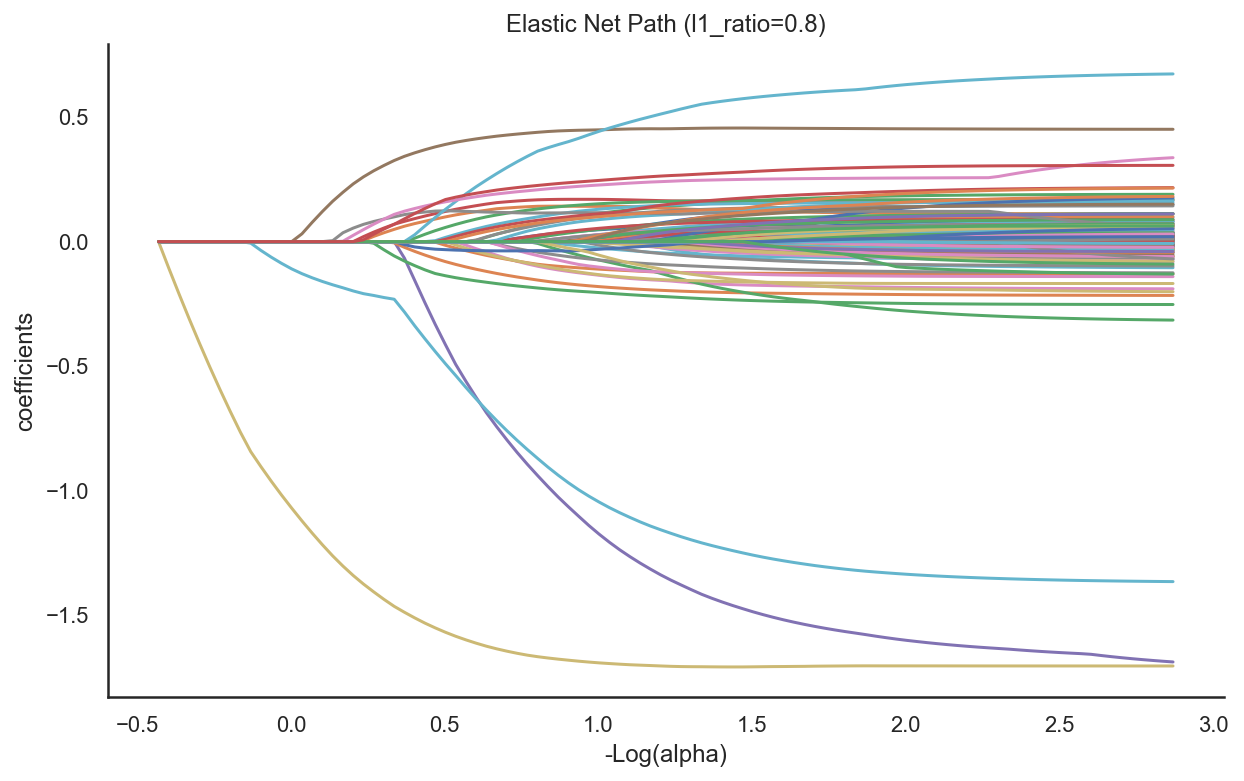

In [58]:
fig, ax = plt.subplots(figsize=(10, 6)) #create
for coef_l in zip(coefs_enet):
    l1 = ax.plot(neg_log_alphas_enet, coef_l[0])


#ax.plot(neg_log_alphas_lasso, coef_l)
#ax.set(xlabel='ICD code', ylabel='occurence',
       #title='Distribution of ICD codes')
sns.despine()
#ax.xaxis.set_major_locator(plt.MaxNLocator(12))
#plt.axhline(y=300, color='goldenrod',linewidth=2,linestyle='--')
#plt.text('D166', 1500, 'threshold: <300', {'color': 'goldenrod', 'fontsize': 15})
#plt.savefig("test_ICD.pdf", dpi=150)
#plt.savefig("test_ICD_1.pdf", dpi=600)
plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic Net Path (l1_ratio=0.8)')
plt.axis('tight')
plt.savefig("enet_path_more variables.pdf", dpi=1000)

## Tuning the hyperparameter alpha

- Cross validation using Regular coordinate descent

In [23]:
 from sklearn.linear_model import LassoCV
X, y = normed_train_data,train_labels
regLCV = LassoCV(eps=1e-4, n_alphas=1000,fit_intercept =False,precompute='auto',max_iter=100000, cv=10,n_jobs=-1, random_state=2).fit(X, y)

- Alpha:

In [24]:
regLCV.alpha_

0.1874277387869883

- Visualizing cross-validation loss

(0.0031622776601683794, 0.1)

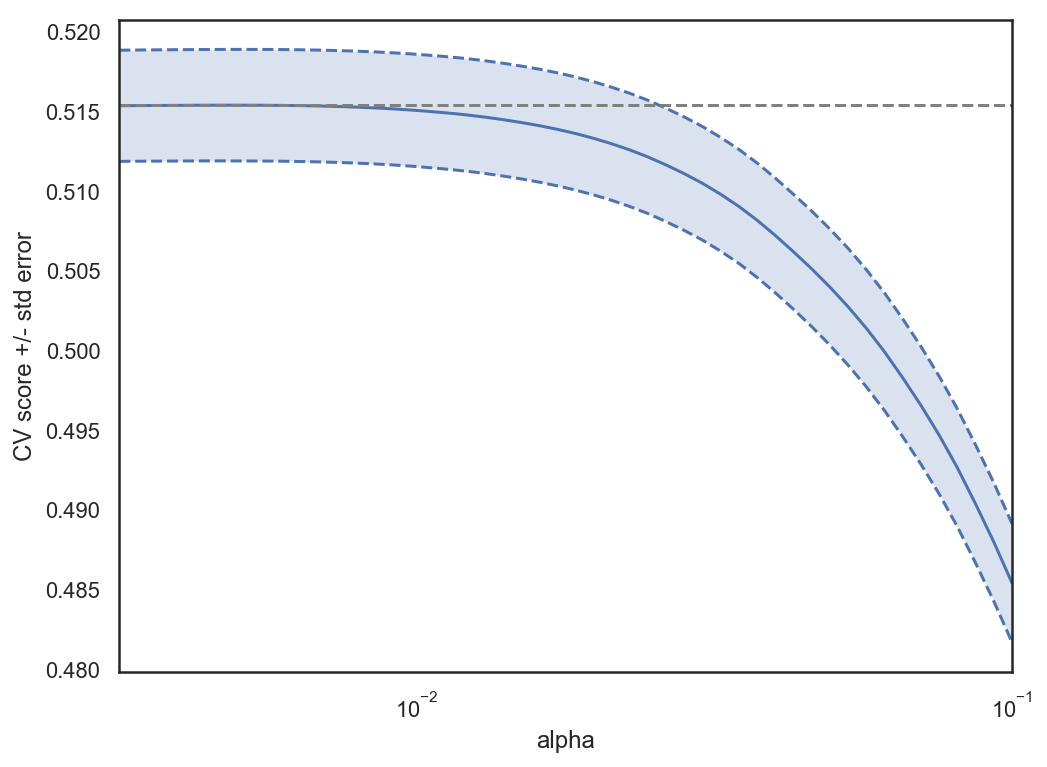

In [82]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

X = normed_train_data
y = train_labels

lasso = Lasso(random_state=1, max_iter=100000)
alphas = np.logspace(-2.5, -1, 50)

tuned_parameters = [{'alpha': alphas}]
n_folds = 10

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

- But we need to find the best combination of both alpha and L1_ratio: cross validation on elastic net

In [60]:
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=300, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

In [61]:
train_X=pd.concat([ normed_train_data, normed_test_data])
train_y=pd.concat([train_labels, test_labels])
cv_model.fit(train_X, train_y)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=1000,
       n_alphas=300, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [62]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00472254
Optimal l1_ratio: 1.000
Number of iterations 34


We see that the elastic net is pushed towards a regular LASSO (L1 ratio=1)

# Short glimpse into inference
- Let's see the importance of each feature based on the absolute value of their coefficients

In [58]:
from sklearn import linear_model
reg1 = linear_model.Lasso(alpha=regLCV.alpha_)
reg1.fit(normed_train_data, train_labels) 

Lasso(alpha=0.1874277387869883, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [59]:
final=zip(reg1.coef_,list(normed_train_data))
final
Features_sorted_1=sorted(final, reverse=True)

- Keep only non-zero  coefficients

In [61]:
important=[x for x in Features_sorted_1 if x[0]!=0]
ListCVi=[(x[0], get_def(x[1])) for x in important]
Cl_keep=[get_def(x[1]) for x in important]

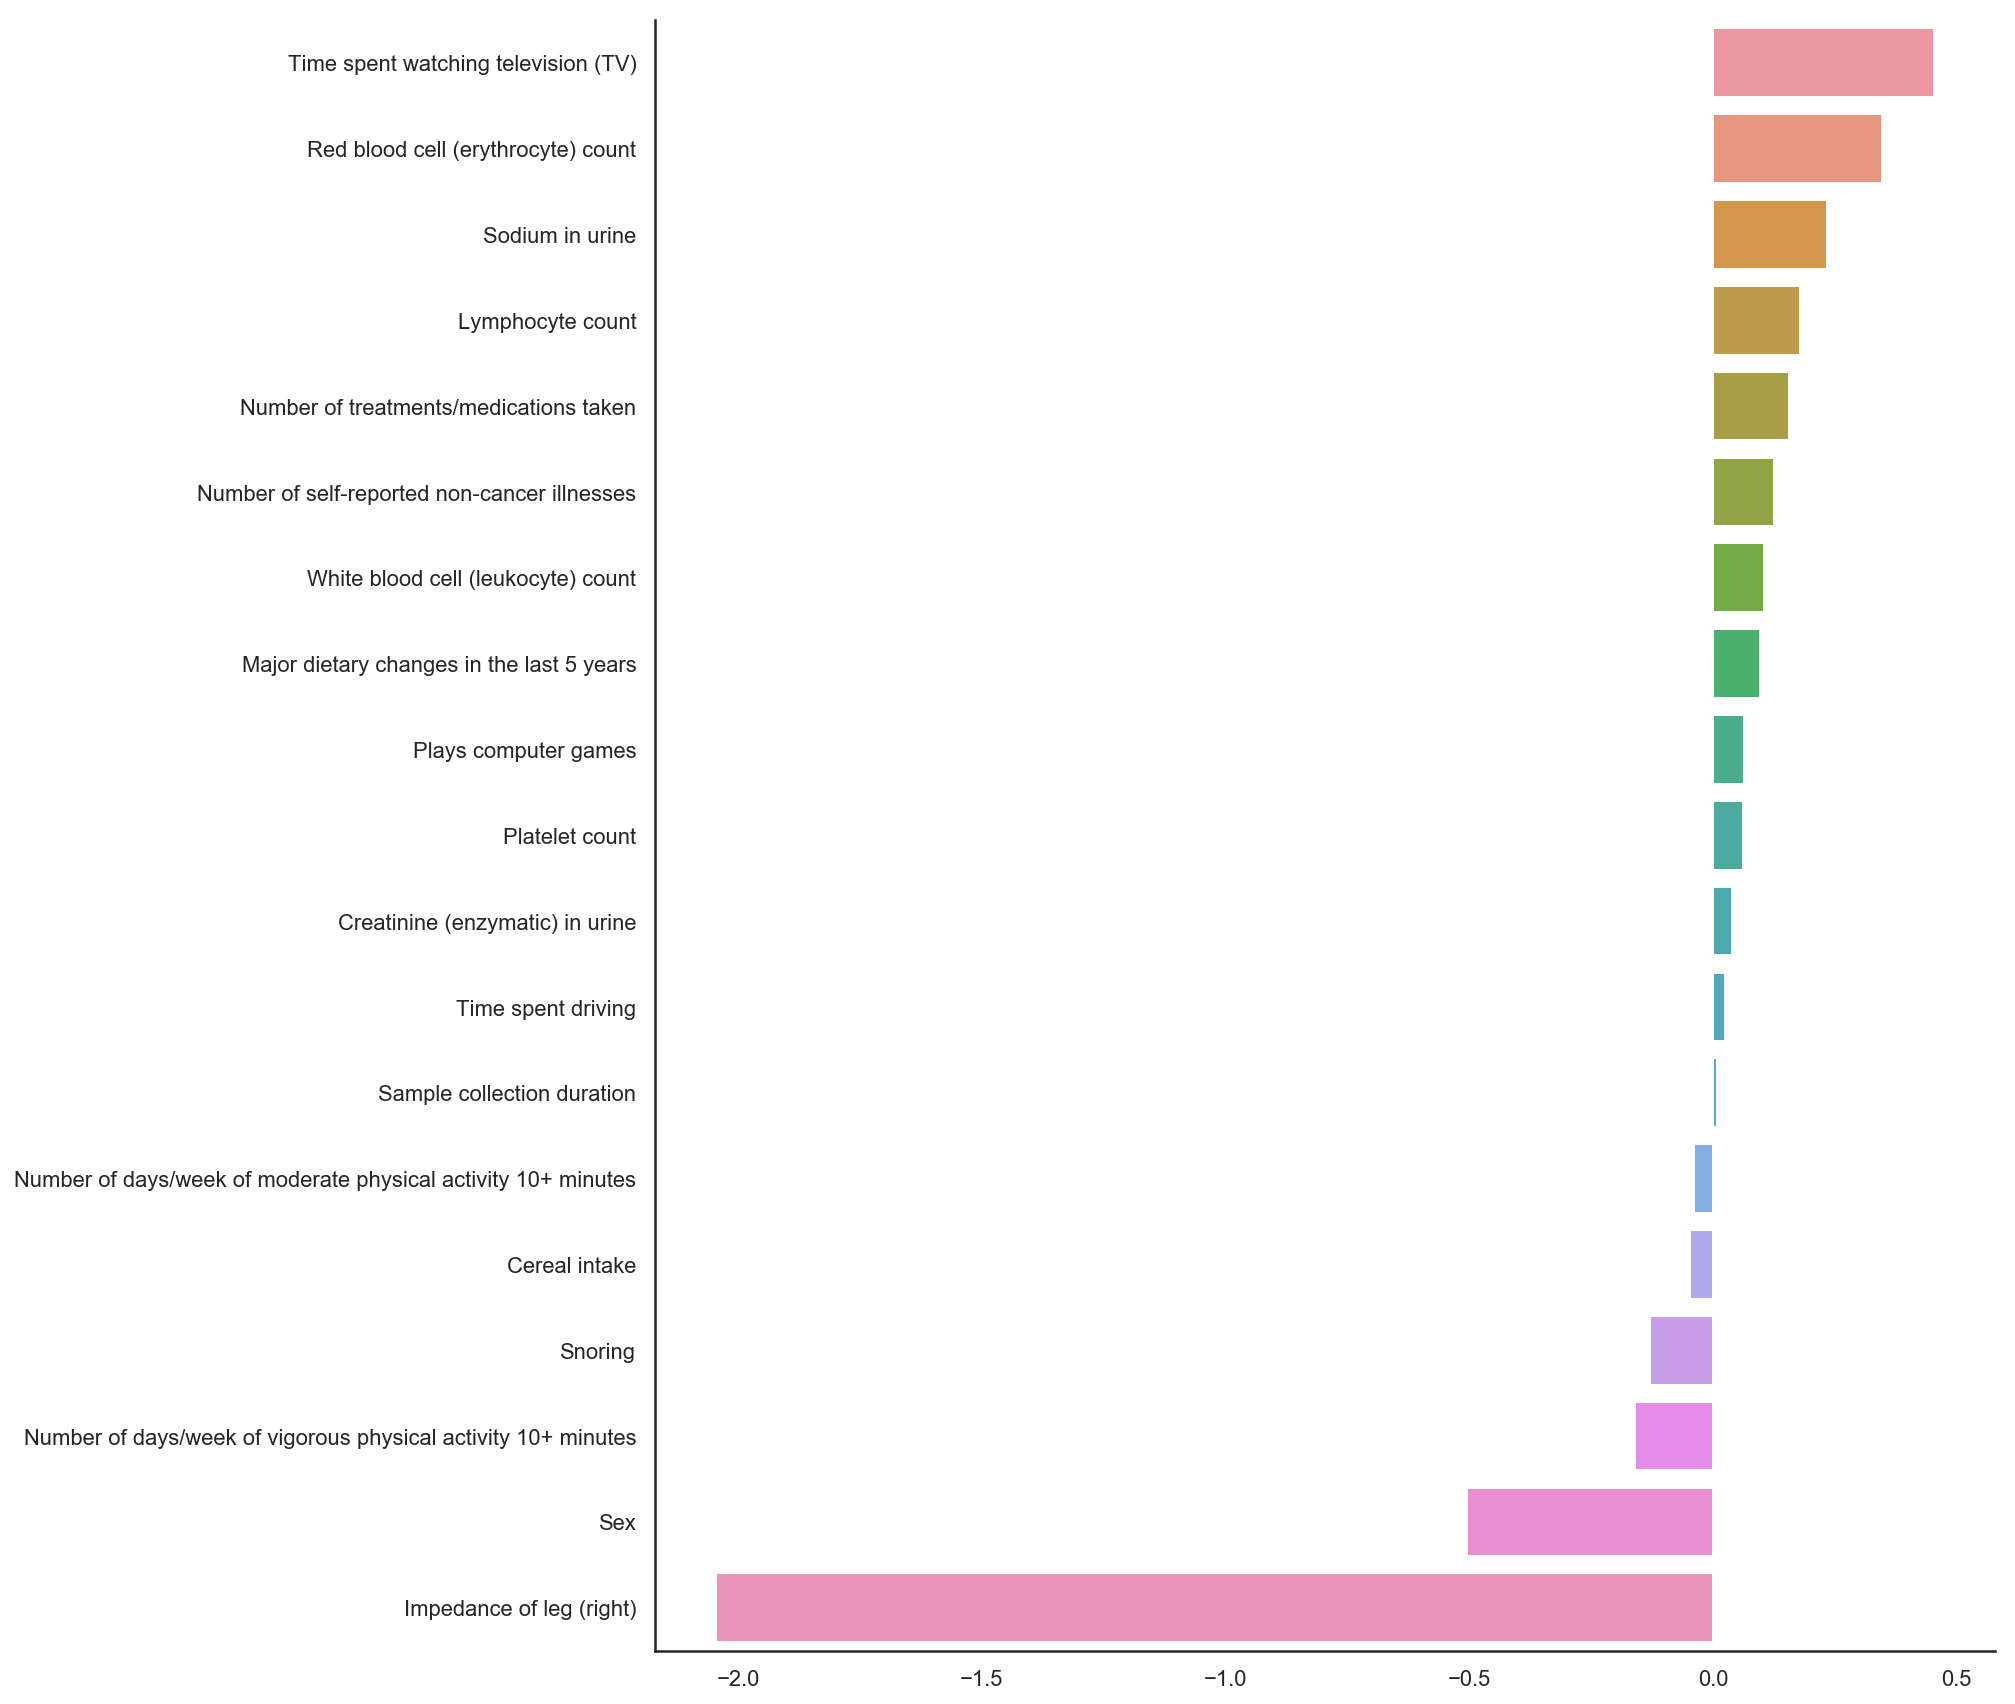

In [70]:
fig5, ax5 = plt.subplots(figsize=(12, 15)) #create
x=[x[0] for x in ListCVi]
y=[x[1] for x in ListCVi]
sns.despine()
ax=sns.barplot(x,y)
plt.savefig("first.pdf", dpi=800,bbox_inches='tight')